In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
import numpy as np
from qiskit.circuit.library import QAOAAnsatz
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from pyDOE import lhs

### Problem

$$\text{Maximize } z = 20x_1 + 40x_2 + 20x_3 + 15x_4 + 30x_5$$

#### Restrictions

Year 1:  $ 5x_1 + 4x_2 + 3x_3 + 7x_4 + 8x_5 \leq 25$

Year 2:  $ 1x_1 + 7x_2 + 9x_3 + 4x_4 + 6x_5 \leq 25$

Year 3:  $ 8x_1 + 10x_2 + 2x_3 + 1x_4 + 10x_5 \leq 25$

In [4]:
def hamiltonian_offset(problem):
    return problem.to_ising()

def create_circuit(hamiltonian, p, optmization_level, backend):
    circuit = QAOAAnsatz(cost_operator=hamiltonian, reps=p)
    circuit.measure_all()

    pm = generate_preset_pass_manager(optimization_level=optmization_level, backend=backend)

    return pm.run(circuit)

def cost_function_estimator(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    return cost

In [5]:
backend = AerSimulator()

def to_bitstring(integer, num_bits):
    binwidth = len(np.binary_repr(integer))
    width = max(num_bits, binwidth)
    result = np.binary_repr(integer, width=width)
    return [int(digit) for digit in result]


def run_experiment(repetitions, num_qb, p, shots_estimator, shots_sampler, optimization_level, hamiltonian):
    circuit = create_circuit(hamiltonian, p, optimization_level, backend)

    estimator = Estimator(mode=backend)
    estimator.options.default_shots = shots_estimator

    sampler  = Sampler(mode=backend)
    sampler.options.default_shots = shots_sampler

    most_likely_bitstrings = []
    for _ in range(repetitions):
        innitial_gamma = 2 * np.pi * np.random.rand()
        innitial_beta = 2 * np.pi * np.random.rand()
        init_params = [val for _ in range(p) for val in (innitial_gamma, innitial_beta)]

        result = minimize(cost_function_estimator, init_params, args=(circuit, hamiltonian, estimator), method="COBYLA", tol=1e-2)

        parameterized_circuit = circuit.assign_parameters(result.x)
        pub = (parameterized_circuit, )
        job = sampler.run([pub])
        counts_int = job.result()[0].data.meas.get_int_counts()
        counts_bin = job.result()[0].data.meas.get_counts()
        shots = sum(counts_int.values())
        final_distribution_int = {key: val/shots for key, val in counts_int.items()}
        final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

        keys = list(final_distribution_int.keys())
        values = list(final_distribution_int.values())
        most_likely = keys[np.argmax(np.abs(values))]
        most_likely_bitstring = to_bitstring(most_likely, num_qb)
        most_likely_bitstring.reverse()
        most_likely_bitstrings.append(most_likely_bitstring)

    
    return most_likely_bitstrings

In [6]:
dark_purple = '#523483'
# light_purple = '#baa9d3' 

def plot_graph_bitstrings_results(results, top=None):
    bitstring_results = ["".join(map(str, sublist)) for sublist in results]
    counts = Counter(bitstring_results)

    if top is not None:
        selected_bitstrings = list(counts.keys())[:top]
    else:
        selected_bitstrings = list(counts.keys())

    occurrences = [counts[bitstring] for bitstring in selected_bitstrings]

    invalid_states = {"01111", "11001", "11011", "11111", "11101"}
    optimum_state = {"11110"}

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title("Results")
    plt.xlabel("Bitstrings")
    plt.ylabel("Occurrences")

    bars = ax.bar(selected_bitstrings, occurrences, color="tab:grey")

    if selected_bitstrings:
        most_common_bitstring = max(selected_bitstrings, key=lambda b: counts[b])
        for i, bitstring in enumerate(selected_bitstrings):
            if bitstring in optimum_state:
                bars[i].set_color("tab:pink")  
            elif bitstring == most_common_bitstring:
                bars[i].set_color(dark_purple)    
            elif bitstring in invalid_states:
                bars[i].set_color("tab:blue")     

    legend_patches = [
        mpatches.Patch(color="tab:pink", label="Expected optimum state"),
        mpatches.Patch(color="tab:blue", label="Invalid states"),
        mpatches.Patch(color=dark_purple, label="Most probable state"),
        mpatches.Patch(color="tab:grey", label="Other states")
    ]
    ax.legend(handles=legend_patches, loc="upper right")
    plt.tight_layout()
    plt.show()

In [7]:
def create_project_selection_qubo(alpha):
    mu = [20, 40, 20, 15, 30]  # Expected returns from each project
    constraints = [
        [5, 4, 3, 7, 8],  # restriction 1
        [5, 7, 9, 4, 6],  # restriction 2
        #[8, 10, 2, 3, 10],  # restriction 3
    ]
    rhs = [25, 25]  

    # Initialize empty QUBO model
    qp = QuadraticProgram('Project_Selection_QUBO')

    for i in range(len(mu)):
        qp.binary_var(name=f'x{i}')

    qp.minimize()

    # original objective function
    for i in range(len(mu)):
        qp.objective.linear[f'x{i}'] = -mu[i]

    for coeffs, limit in zip(constraints, rhs):
        # Constant term from penalty expansion 
        qp.objective.constant += alpha * (limit ** 2) 
        # Linear terms from penalty expansion [(-2α * b * c_i * x_i)]
        for i in range(len(mu)):
            qp.objective.linear[f'x{i}'] += -2 * alpha * limit * coeffs[i]
            # All quadratic cross terms [(α * c_i * c_j * x_i * x_j)]
            for j in range(len(mu)):
                qp.objective.quadratic[f'x{i}', f'x{j}'] += alpha * coeffs[i] * coeffs[j]

    return qp

In [8]:
alpha = 1000 #test
qubo = create_project_selection_qubo(alpha)

print(qubo.prettyprint())

Problem name: Project_Selection_QUBO

Minimize
  50000*x0^2 + 110000*x0*x1 + 120000*x0*x2 + 110000*x0*x3 + 140000*x0*x4
  + 65000*x1^2 + 150000*x1*x2 + 112000*x1*x3 + 148000*x1*x4 + 90000*x2^2
  + 114000*x2*x3 + 156000*x2*x4 + 65000*x3^2 + 160000*x3*x4 + 100000*x4^2
  - 500020*x0 - 550040*x1 - 600020*x2 - 550015*x3 - 700030*x4 + 1250000

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [9]:
hamiltonian, offset = hamiltonian_offset(qubo)
print(hamiltonian, offset)

SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[105010. +0.j, 112520. +0.j, 120010. +0.j, 118507.5+0.j, 149015. +0.j,
  27500. +0.j,  30000. +0.j,  27500. +0.j,  35000. +0.j,  37500. +0.j,
  28000. +0.j,  37000. +0.j,  28500. +0.j,  39000. +0.j,  40000. +0.j]) 314937.5


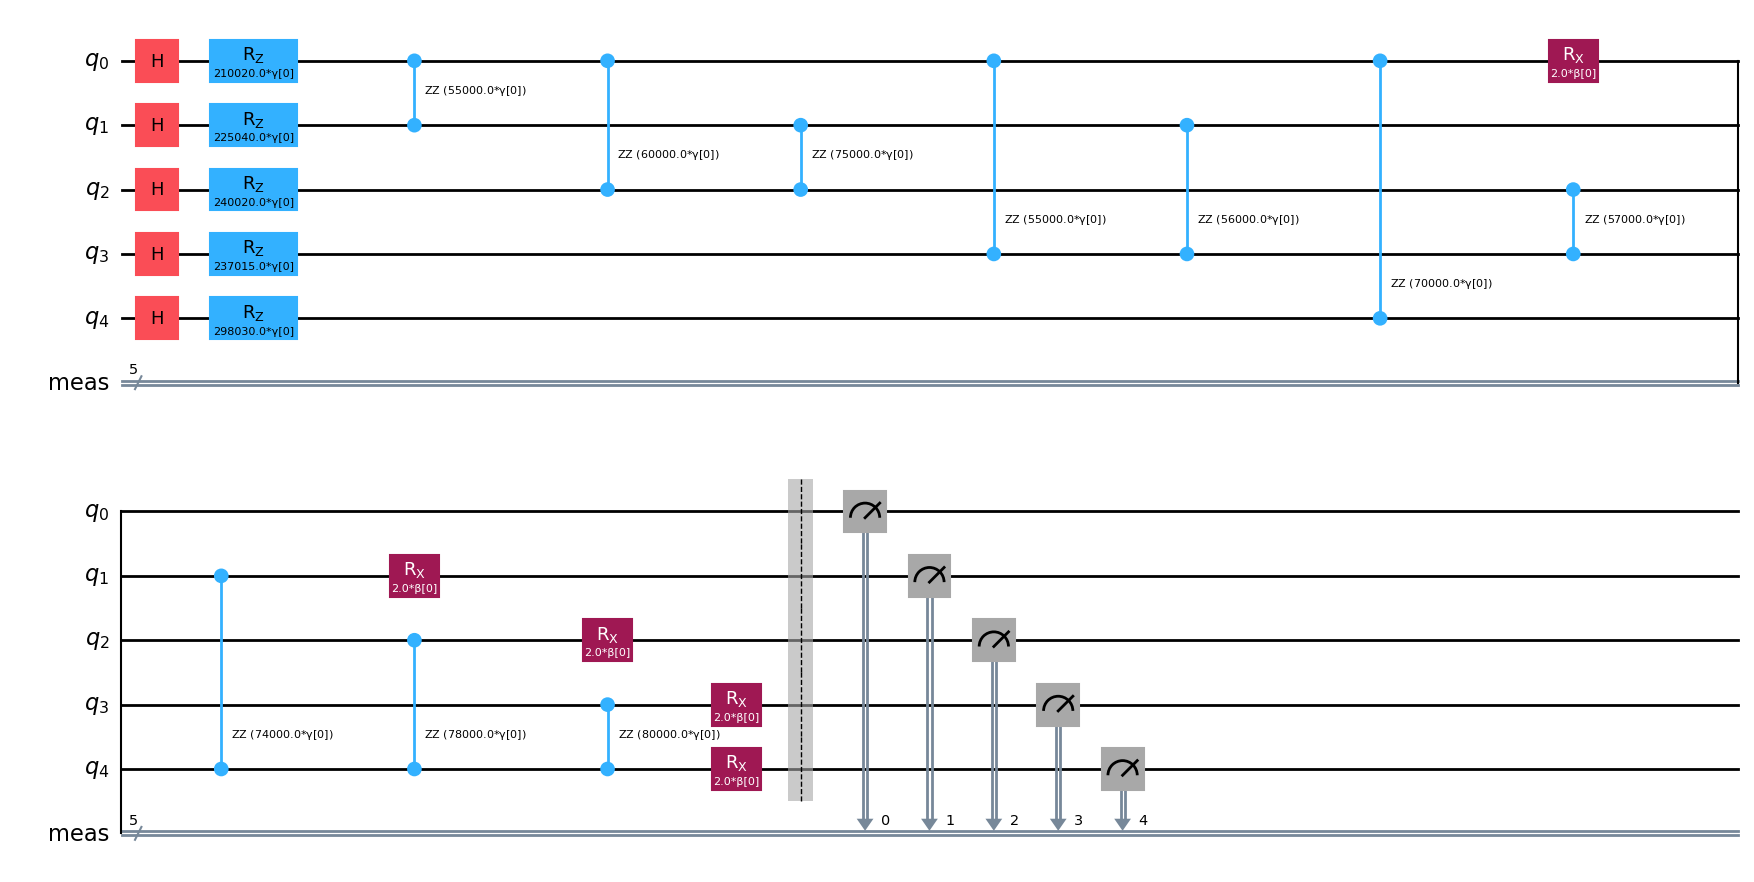

In [10]:
circuit = create_circuit(hamiltonian, 1, 3, backend)

circuit.draw(output="mpl", style="iqp")

In [11]:
results = run_experiment(60, 5, 6, 10000, 10000, 3, hamiltonian)

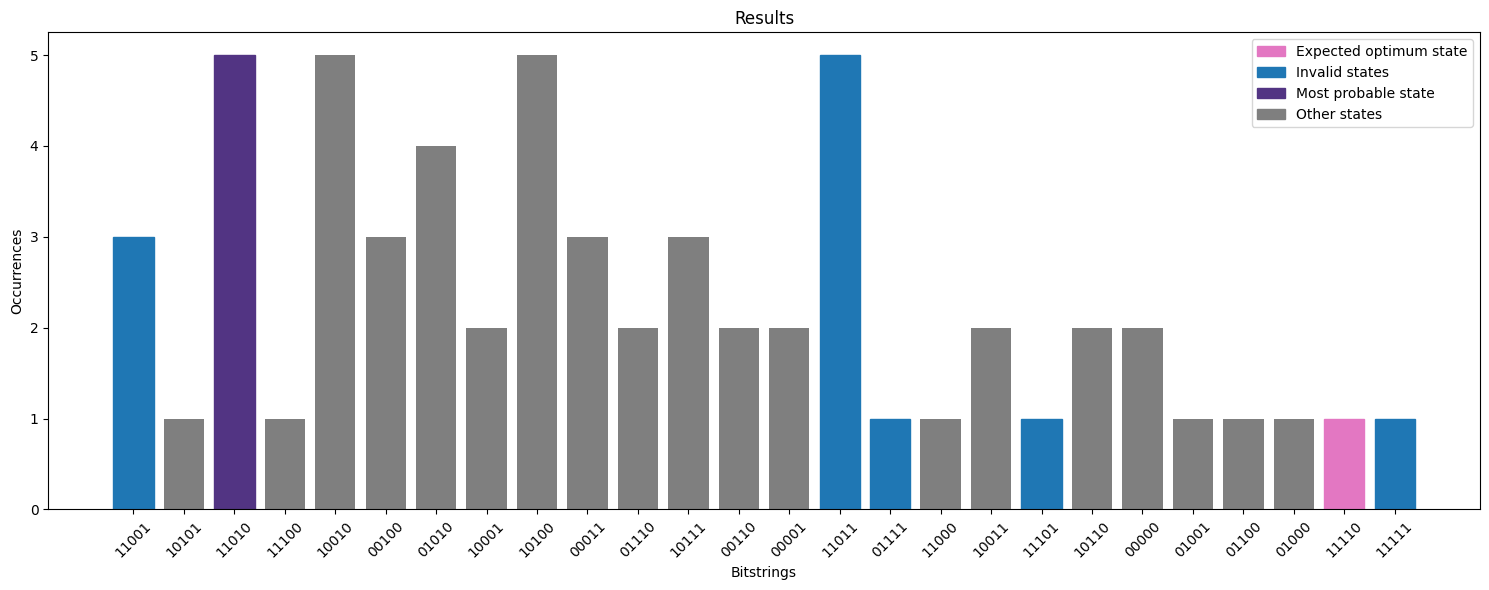

In [12]:
plot_graph_bitstrings_results(results)